
# Build a Tool-Use ReAct Agentic AI System with LangGraph

## Problem Statement

In this notebook, we will be building an Agentic AI system — HealthBuddy — using LangGraph with built-in utility functions. This system will act as an intelligent assistant that can:

- Understand user queries about health
- Research using web and arXiv tools
- Recommend appropriate doctors based on user symptoms

We will follow the **ReAct principle** (Reason + Act) to let the agent think, use tools when needed, observe results, and provide a well-formed final answer. Instead of relying on built-in LLM knowledge alone, the agent will use **external tools** to gather accurate and helpful information before responding.


---

### Objective:

Our goals in this notebook are:

- **Build a ReAct-based Tool-Use Agent using LangGraph with built-in utility functions like `create_react_agent()`**
- Equip the agent with multiple tools (web search, arXiv search, doctor recommendation)
- Handle user queries end-to-end — from interpreting intent to delivering a useful, cited, and grounded response
- Simulate a multi-step reasoning and tool-using workflow

By the end of this notebook, we will have a working agent that can research a health query, gather relevant information, and offer advice including suggesting a doctor — all through structured decision-making and tool usage.

### Agent Architecture:

The following figure shows the agent architecture including all the components and the overall workflow

![](https://i.imgur.com/efDt1tq.png)


In [ ]:
!pip install langgraph==1.0.2 langchain==1.0.5 langchain-openai==1.0.2 langchain-community==0.4.1 arxiv==2.3.0 pymupdf==1.26.6

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

## Load Necessary Dependencies

In [ ]:
import json
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Image, Markdown

## Setup Authentication and LLM Client

Here we authenticate and connect to necessary LLM using OpenAI Authentication

In [ ]:
import os
import getpass

# OpenAI API Key (for chat & embeddings)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key (https://platform.openai.com/account/api-keys):\n")

# Tavily API Key (for web search)
if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key (https://app.tavily.com/home):\n")

Enter your OpenAI API key (https://platform.openai.com/account/api-keys):
··········
Enter your Tavily API key (https://app.tavily.com/home):
··········


In [ ]:
llm_client = ChatOpenAI(model_name="gpt-4o-mini")

## Preparing Database for Doctor Recommendations Tool

In this section, we will create a small, in-memory database that contains information about doctors. This data will be used by our **Doctor Recommendation Tool**, which will help users find the right doctor based on their health query or symptoms.

The database includes a list of doctors along with their:
- Name
- Specialization (e.g., Dermatology, Pediatrics, Cardiology)
- Location
- Availability
- Contact information

We are using a simple Python list of dictionaries to store the doctor data. This keeps it easy to understand and modify. In a real-world application, this would typically be replaced by a backend database like PostgreSQL, MongoDB, or an external API.

We will build a tool later on to use this data to recommend doctors based on the user's needs — for example, suggesting a pediatrician for a child’s fever or a cardiologist for chest pain.

In [ ]:
# loading our doctors dataset
doctors_db = [
    {"name": "Dr. Janet Dyne", "specialization": "Endocrinology (Diabetes Care)", "available_timings": "10:00 AM - 1:00 PM", "location": "City Health Clinic", "contact": "janet.dyne@healthclinic.com"},
    {"name": "Dr. Don Blake ", "specialization": "Cardiology (Heart Specialist)", "available_timings": "2:00 PM - 5:00 PM", "location": "Metro Cardiac Center", "contact": "don.blake@metrocardiac.com"},
    {"name": "Dr. Susan D'Souza", "specialization": "Oncology (Cancer Care)", "available_timings": "11:00 AM - 2:00 PM", "location": "Hope Cancer Institute", "contact": "susan.dsouza@hopecancer.org"},
    {"name": "Dr. Matt Murdock", "specialization": "Psychiatry (Mental Health)", "available_timings": "4:00 PM - 7:00 PM", "location": "Mind Care Center", "contact": "matt.murdock@mindcare.com"},
    {"name": "Dr. Dinah Lance", "specialization": "General Physician", "available_timings": "9:00 AM - 12:00 PM", "location": "Downtown Medical Center", "contact": "dinah.lance@downtownmed.com"}
]

## Create Tools for AI Agent

In this section, we will define the tools that our AI Agent will use to perform specific tasks.

LangChain makes it easy to create and register tools using the `Tool` class. A tool includes:
- A name and description
- The python function to be called
- An input schema that tells the model what arguments it can use

When tools are defined properly, they help the model solve more complex problems by letting it take actions and use external data. This makes the system more useful and reliable.

### 🧪 Example
```python
from langchain.tools import tool

@tool
def search_web(query: str) -> str:
    """Get live information for user queries from the web."""
    # assuming we have a google_search function implemented to search on google
    return google_search(query)
```

These tools will allow the agent to retrieve information from our preloaded vector databases (web search and PubMed), as well as recommend doctors from our in-memory doctor database.

The goal is to modularize the logic for different types of tasks into reusable components that can be invoked by the LLM when needed. These include:

- A **Web Search Tool** that queries the web to get relevant information through web search
- A **ArXiv Search Tool** that retrieves information from top research papers from arxiv.org relevant to the query  
- A **Doctor Recommendation Tool** that finds suitable doctors based on user symptoms or needs

This tool-based setup is essential for enabling agentic behavior, where the LLM reasons through a problem, decides which action to take, and requests to call the right tools to gather more information or perform a task.


In [ ]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_community.retrievers import ArxivRetriever

# Tool for web search on general health topics
# Tavily Web Search
tavily_search = TavilySearchAPIWrapper()

@tool
def search_web(query: str) -> list:
    """
    Search the web for general or up-to-date information on healthcare topics.

    Inputs:
    - query (str): The search query string. Should describe the healthcare topic or information you want to find.

    Outputs:
    - list: A list of up to 3 formatted strings, each containing:
        - Title of the search result
        - Content extracted from the page
        - Source URL
    """
    results = tavily_search.raw_results(query=query, max_results=3, search_depth='advanced',
                                        include_answer=False, include_raw_content=True)
    docs = results['results']
    docs = [doc for doc in docs if doc.get("raw_content") is not None]
    docs = ['## Title\n'+doc['title']+'\n\n'+'## Content\n'+doc['raw_content']+'\n\n'+'##Source\n'+doc['url'] for doc in docs]
    return docs


# Tool for arXiv Search
# arxiv search retriever
arxiv_retriever = ArxivRetriever(
    top_k_results=3,
    get_full_documents=True,
    doc_content_chars_max=20000
)

@tool
def search_arxiv(query: str) -> list:
    """
    Search arXiv for relevant scientific research papers and articles.

    Inputs:
    - query (str): The research topic or keywords to search for on arXiv.

    Outputs:
    - list: A list of up to 3 formatted strings, each containing:
        - Title of the paper
        - Summary of the paper
        - Full content (truncated to maximum allowed characters)
      Returns ["No articles found for the given query."] if no matches are found.
    """
    try:
        results = arxiv_retriever.invoke(query)
        if results:
            articles = ['## Title\n'+doc.metadata['Title']+'\n\n'+'## Summary\n'+doc.metadata['Summary']+'\n\n'+'##Content\n'+doc.page_content for doc in results]
            return articles
        else:
            return ["No articles found for the given query."]
    except Exception as e:
        return [f"Error fetching arXiv articles: {str(e)}"]


@tool
def recommend_doctor(query: str) -> dict:
    """
    Recommend the most suitable doctor based on the user's symptoms or health-related query.

    Inputs:
    - query (str): A description of the patient's symptoms or healthcare needs.

    Outputs:
    - dict: A dictionary containing:
        - "recommended_doctor": JSON-formatted details of the selected doctor from the `doctors_db`.
          If the most suitable match cannot be determined, defaults to recommending the General Physician.
    """
    doctors_list = str(doctors_db)
    prompt = f"""You are an assistant helping recommend a doctor based on patient's health issues.

                 Here is the list of available doctors:
                {doctors_list}

                Given the user's query: "{query}"

                Choose the most suitable doctor from the list. Only pick one doctor.
                Return only the selected doctor's information in JSON format (no markdown).
                If not sure, recommend the General Physician.
              """
    # qcom_llm = .,,,,,
    response = llm_client.invoke(prompt)
    return {"recommended_doctor": response}

## Define Tools to be Used by the Agent

In this section, we define the tools that our AI agent will use when reasoning through user queries. These include:

- `search_web`: To fetch general health-related information from the internet.
- `search_arxiv`: To retrieve scientific research papers from arXiv.org.
- `recommend_doctor`: To recommend a suitable doctor based on the user's symptoms.

These tools are already defined and registered using the `@tool` decorator. Here, we simply collect them into a list to be fed into the agent function later on.


In [ ]:
# List of all tools that the LLM should be aware of
# These tools were defined earlier using the @tool decorator
tools = [search_web, search_arxiv, recommend_doctor]

## Define Agent Instructions Prompt

To guide the LLM-based agent, we provide a custom system prompt that sets the role and behavior of the assistant.

The prompt clearly instructs the agent to:
- Act as a helpful healthcare assistant
- Reason on input queries and do the following:
  - Research the query using the most relevant tools (web, pubmed)
  - Recommend a doctor only if appropriate

This prompt plays a critical role in shaping how the agent reasons, decides when to call tools, and how to construct final responses. It supports ReAct-style behavior where the model reflects, takes actions (via tools), and continues reasoning.

In [ ]:
# Instruction prompt for the overall Agent
AGENT_PROMPT_TXT = r"""You are an agent designed to act as an expert in researching on medical symptoms
and also recommend relevant doctors for booking appointments.
Also remember the current year is 2025 and use the same for all search queries when no specific dates are mentioned.

Given an input user query call relevant tools and give the most appropriate response.
Follow some of these guidelines to help you make more informed decisions:
  - If the user's query specifies recommending a doctor only then recommend an appropriate doctor
  - If the user is researching on detailed and specific aspects around symptoms, treatments and other aspects related to healthcare
  use both search_web and search_arxiv tools to get comprehensive information and then give a well-structured response
  - If the user is just looking for general information around healthcare then web search is enough
  - Use search_arxiv tool only if the query is related to information which might be found in research papers
  - Response should include cited source links and \ or arXiv Article Title, Publication Dates if available
  - If recommending doctors then use the recommend_doctor and show detailed information in a nice structured way and recommend them to book an appointment via email
  - Politely decline answering any queries not related to medical or healthcare information
"""

AGENT_SYS_PROMPT = SystemMessage(content=AGENT_PROMPT_TXT)

## Create our Tool-Use AI Agent

Using the tools, prompt, and LLM setup, we now create the actual **Tool-Use Agent** using LangChain’s built-in `create_react_agent()` utility function.

This creates a simple ReAct-style agent capable of:
- Receiving a user query
- Reasoning on next steps
- Calling the appropriate tool(s) if needed
- Observing tool outputs
- Returning a final answer

This step brings together everything we’ve built so far: tools, instructions, and reasoning logic into a functioning agentic loop.

In [ ]:
# Create our agent using tools, LLM and instruction prompt
healthbuddy_agent = create_react_agent(model=llm_client,
                                       tools=tools,
                                       prompt=AGENT_SYS_PROMPT)

/tmp/ipython-input-416506609.py:2: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  healthbuddy_agent = create_react_agent(model=llm_client,


You can update this and use the `create_agent` function from LangChain agents only if you are using version > 1.0, in production if you are using version < 1.0 then you can continue using the above (recommended especially as LangChain 1.0 just came out and expect them to break more stuff!)

In [ ]:
from langchain.agents import create_agent

healthbuddy_agent = create_agent(model=llm_client,
                                 tools=tools,
                                 system_prompt=AGENT_PROMPT_TXT) # just send prompt text directly here

## View our Agent Flow


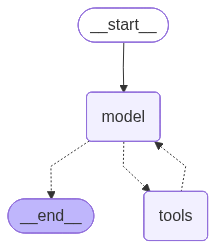

In [ ]:
display(Image(healthbuddy_agent.get_graph().draw_mermaid_png()))

## Build Utility Function to Stream Agent Results

We define a helper function to stream the step-by-step output of the agent. This makes it easier to trace:
- What the agent doing in each step
- Which tool it decides to call
- What response it gets from that tool
- How it forms the final reply

Streaming output is helpful when evaluating multi-step reasoning and debugging tool use in real time.

In [ ]:
# get agent streaming utils
!gdown 1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB

Downloading...
From (original): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB
From (redirected): https://drive.google.com/uc?id=1dSyjcjlFoZpYEqv4P9Oi0-kU2gIoolMB&confirm=t&uuid=10da76d9-8717-4601-8001-eaabff652253
To: /content/agent_utils.py
100% 6.45k/6.45k [00:00<00:00, 19.2MB/s]


In [ ]:
from agent_utils import format_message

# Utility function to call the agent and stream its step-by-step reasoning
def call_agent(agent, query, verbose=False):

    # Stream the agent's execution with the given query
    for event in agent.stream(
        {"messages": [HumanMessage(content=query)]}, # input prompt
        stream_mode='values'  # Stream output as intermediate values
    ):
        # If verbose is enabled, print each intermediate message step-by-step
        if verbose:
            format_message(event["messages"][-1])

    # Display the final response from the agent as Markdown
    print('\n\nFinal Response:\n')
    display(Markdown(event["messages"][-1].content))

    # Return the overall event messages for optional downstream use
    return event["messages"]


## Test out our Agent!

In this final section, we run a complete test of our Tool-Use AI Agent by passing it a sample health-related query.

We observe how the agent:
- Interprets the query
- Decides which tool(s) to use (if any)
- Executes tool calls
- Streams the intermediate steps and final output

In [ ]:
# Example usage
query = "what are the latest methods for diabetes management and recommend a doctor please"
result = call_agent(healthbuddy_agent, query, verbose=True)

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what are the latest methods for diabetes management and recommend a doctor please                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: search_web                                                                                        │
│    Args: {                                                                                                      │
│   "query": "latest methods for diabetes management 2025"                                                        │
│ }                                                                                                               │
│    ID: call_R6ToyLdkwnwp0Z0gh3CmH2mj                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: recommend_doctor                                                                                  │
│    Args: {                                                                                                      │
│   "query": "diabetes management"                                                                                │
│ }                                                                                                               │
│    ID: call_gDSmwWfaAjB3pYaBAKXVmtau                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'recommended_doctor': AIMessage(content='{\n  "name": "Dr. Janet Dyne",\n  "specialization": "Endocrinology    │
│ (Diabetes Care)",\n  "available_timings": "10:00 AM - 1:00 PM",\n  "location": "City Health Clinic",\n          │
│ "contact": "janet.dyne@healthclinic.com"\n}', additional_kwargs={'refusal': None},                              │
│ response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 387, 'total_tokens': 456,          │
│ 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,        │
│ 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},            │
│ 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559',      │
│ 'id': 'chatcmpl-CZagubdp8I4HAmEaxeWCHMHunN4ST', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': │
│ None}, id='lc_run--9b801946-9fed-48bd-8fea-d170d63a3ca2-0', usage_metadata={'input_tokens': 387,                │
│ 'output_tokens': 69, 'total_tokens': 456, 'input_token_details': {'audio': 0, 'cache_read': 0},                 │
│ 'output_token_details': {'audio': 0, 'reasoning': 0}})}                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ ### Latest Methods for Diabetes Management                                                                      │
│                                                                                                                 │
│ The management of diabetes, particularly type 2 diabetes, has seen significant advancements, especially in the  │
│ areas of treatment, lifestyle intervention, and monitoring. Key updates in diabetes management as of 2025       │
│ include:                                                                                                        │
│                                                                                                                 │
│ 1. **Lifestyle Interventions**:                                                                                 │
│    - Lifestyle changes remain foundational in diabetes management, emphasizing diet and physical activity.      │
│    - Intensive lifestyle interventions (ILI) can lead to significant improvements in glycemic control.          │
│                                                                                                                 │
│ 2. **Medications**:                                                                                             │
│    - **SGLT2 Inhibitors**: These drugs (e.g., empagliflozin) have shown substantial benefits in reducing        │
│ cardiovascular and kidney-related risks in patients with diabetes.                                              │
│    - **GLP-1 Receptor Agonists**: Medications like semaglutide and tirzepatide not only help in glycemic        │
│ control but also promote weight loss and improve cardiovascular health.                                         │
│    - **Resmetirom**: Recently approved for metabolic dysfunction-associated steatohepatitis (MASH), showcasing  │
│ a novel approach for liver health in diabetes patients.                                                         │
│                                                                                                                 │
│ 3. **Technology in Care**:                                                                                      │
│    - Continuous Glucose Monitoring (CGM) systems have enhanced the ability to manage blood glucose levels       │
│ effectively, facilitating timely interventions.                                                                 │
│                                                                                                                 │
│ 4. **Screening and Management of Complications**:                                                               │
│    - Regular screening for cardiovascular disease (CVD) and chronic kidney disease (CKD) is now recommended due │
│ to the intertwining relationships these conditions have with diabetes.                                          │
│    - Enhanced understanding of the need for early intervention to prevent complications has led to more         │
│ comprehensive guideline recommendations.                                                                        │
│                                                                                                                 │
│ 5. **Focus on Mental Health**:                                                                                  │
│    - Increased acknowledgment of the psychological aspects of diabetes management, including routine screening  │
│ for diabetes distress and anxiety, emphasizing holistic patient care.                                           │
│                                                                                                                 │
│ For a more detailed account of these methods, the [International Diabetes Federation (IDF) Recommendations for  │
│ Managing Type 2 Diabetes 2025](https://idf.org/media/up



Final Response:



### Latest Methods for Diabetes Management

The management of diabetes, particularly type 2 diabetes, has seen significant advancements, especially in the areas of treatment, lifestyle intervention, and monitoring. Key updates in diabetes management as of 2025 include:

1. **Lifestyle Interventions**: 
   - Lifestyle changes remain foundational in diabetes management, emphasizing diet and physical activity.
   - Intensive lifestyle interventions (ILI) can lead to significant improvements in glycemic control.

2. **Medications**:
   - **SGLT2 Inhibitors**: These drugs (e.g., empagliflozin) have shown substantial benefits in reducing cardiovascular and kidney-related risks in patients with diabetes.
   - **GLP-1 Receptor Agonists**: Medications like semaglutide and tirzepatide not only help in glycemic control but also promote weight loss and improve cardiovascular health.
   - **Resmetirom**: Recently approved for metabolic dysfunction-associated steatohepatitis (MASH), showcasing a novel approach for liver health in diabetes patients.

3. **Technology in Care**:
   - Continuous Glucose Monitoring (CGM) systems have enhanced the ability to manage blood glucose levels effectively, facilitating timely interventions.

4. **Screening and Management of Complications**:
   - Regular screening for cardiovascular disease (CVD) and chronic kidney disease (CKD) is now recommended due to the intertwining relationships these conditions have with diabetes.
   - Enhanced understanding of the need for early intervention to prevent complications has led to more comprehensive guideline recommendations.

5. **Focus on Mental Health**:
   - Increased acknowledgment of the psychological aspects of diabetes management, including routine screening for diabetes distress and anxiety, emphasizing holistic patient care.

For a more detailed account of these methods, the [International Diabetes Federation (IDF) Recommendations for Managing Type 2 Diabetes 2025](https://idf.org/media/uploads/2025/04/IDF_Rec_2025.pdf) and the [American Diabetes Association Standards of Care 2025](https://diabetesjournals.org/care/issue/48/Supplement_1) provide extensive insights.

### Recommended Doctor

For diabetes management, I recommend the following healthcare professional:

#### Dr. Janet Dyne
- **Specialization**: Endocrinology (Diabetes Care)
- **Location**: City Health Clinic
- **Available Timings**: 10:00 AM - 1:00 PM
- **Contact**: [janet.dyne@healthclinic.com](mailto:janet.dyne@healthclinic.com)

If you would like to book an appointment, please reach out to Dr. Dyne's office via the provided email address.

In [ ]:
# inspect all agent events separately
for event in result:
    format_message(event)

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ what are the latest methods for diabetes management and recommend a doctor please                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: search_web                                                                                        │
│    Args: {                                                                                                      │
│   "query": "latest methods for diabetes management 2025"                                                        │
│ }                                                                                                               │
│    ID: call_R6ToyLdkwnwp0Z0gh3CmH2mj                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: recommend_doctor                                                                                  │
│    Args: {                                                                                                      │
│   "query": "diabetes management"                                                                                │
│ }                                                                                                               │
│    ID: call_gDSmwWfaAjB3pYaBAKXVmtau                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["## Title\n[PDF] IDF Global Clinical Practice Recommendations for Managing Type 2 ...\n\n## Content\nIDF       │
│ Global Clinical Practice Recommendations for Managing Type 2 Diabetes 2025 IDF Global Clinical Practice         │
│ Recommendations for Managing Type 2 Diabetes 2025 In Memoriam We are deeply saddened by the passing of          │
│ Professor Akhtar Hussain (IDF President 2022-2024), who served as Chair of this initiative and led its          │
│ development. His leadership, dedication, and expertise significantly shaped this publication. We respectfully   │
│ dedicate this work to his memory.\nCorrespondence Prof. Stephen Colagiuri (co-chair), University of Sydney,     │
│ Sydney, Australia. stephen.colagiuri@sydney.edu.au; Prof. Antonio Ceriello (co-chair), IRCCS MultiMedica,       │
│ Milan, Italy. antonio.ceriello@hotmail.it Acknowledgements International Centre for Professional Development in │
│ Health and Medicine (ICPDHM), Team – Canada Bhavadharini Balaji, PhD - Lead medical writer, Alanna Grant, PhD - │
│ Senior medical writer and editorial support, Jenny Anawati, Vice President, Anatoly Langer, MD, MSc, FRCPS(C),  │
│ FACC, Chair, Vivianne Vinet, Chief Executive Officer, IDF Executive Office Lorenzo Piemonte (Belgium) Lucy      │
│ Michaeloudis (France) Paraskevi Salpea (United States) Phil Riley (Belgium) Sameer Pathan (United Kingdom)      │
│ Xango Bimont (France) Sponsors’ duality of interest This update of the 2005 International Diabetes Federation   │
│ (IDF) Global Guideline on type 2 diabetes was supported by educational grants from Sanofi and Servier.\nThese   │
│ companies did not take part in any aspect of the development of these clinical practice recommendations.        │
│ Copyright No part of this publication may be reproduced or transmitted in any form or by any means without the  │
│ written prior permission of the International Diabetes Federation. Requests to reproduce or translate this      │
│ publication should be e-mail at communications@idf.org.\n© International Diabetes Federation, 2025 ISBN         │
│ 978-2-930229-97-3 Please cite this report as International Diabetes Federation. IDF Global Clinical Practice    │
│ Recommendations for Managing Type 2 Diabetes – 2025. https://idf.org/t2d-cpr-2025 Co-chairs: Antonio Ceriello   │
│ (Italy) Contributors: Tadej Battelino (Slovenia) A Enrique Caballero (USA) Juliana CN Chan (Hong Kong, China)   │
│ Francesco Cosentino (Sweden) Amalia Gastadelli (Italy) Per-Henrik Groop (Finland) Akhtar Hussain (Norway) – in  │
│ memoriam David Jenkins (Canada) Linong Ji (China) Stephen Colagiuri (Australia) IDF TECHNICAL WORKING GROUP     │
│ Nebojsa Lalic (Serbia) Carolyn SP Lam (Singapore) Rayaz A Malik (Qatar) Roopa Mehta (Mexico) Viswanathan Mohan  │
│ (India) Renan Magalhães Montenegro Junior (Brazil) Ayesha A Motala (South Africa) Peter E.H. Schwarz (Germany)  │
│ Luc Van Gaal (Belgium) Antonio Pérez (Spain) Gojka Roglic (Switzerland) Banshi Saboo (India) Petar M Seferović  │
│ (Serbia) Jonathan Shaw (Australia) Wayne H-H Sheu (Taiwan, China) Nigel Unwin (UK) Daisuke Yabe (Japan) Jian    │
│ Zhou (China) Project Development, Coordination, and Dissemination Sameer Pathan, Senior Manager at the          │
│ International Diabetes Federation, served as project lead and coordinator for this publication, overseeing its  │
│ development, expert engagement, finalisation, and global dissemination.\nExternal Reviewers: Adel El Sayed      │
│ (Egypt) Mohammed Eslam (Australia) Massimo Federici (Italy) Edward W Gregg (UK) James L Januzzi, Jr (USA)       │
│ Alicia Jenkins (Australia) Anatoly Langer (Canada) Maddalena Lettino (Italy) Geltrude Mingrone (Italy) Bernard  │
│ Omech (Uganda) Foreward Introduction Antonio Ceriello, MD & Stephen Colagiuri, MD Chapter 1 Detection of        │
│ diabetes and intermediate hyperglycaemia, and preventio

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'recommended_doctor': AIMessage(content='{\n  "name": "Dr. Janet Dyne",\n  "specialization": "Endocrinology    │
│ (Diabetes Care)",\n  "available_timings": "10:00 AM - 1:00 PM",\n  "location": "City Health Clinic",\n          │
│ "contact": "janet.dyne@healthclinic.com"\n}', additional_kwargs={'refusal': None},                              │
│ response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 387, 'total_tokens': 456,          │
│ 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,        │
│ 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},            │
│ 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559',      │
│ 'id': 'chatcmpl-CZagubdp8I4HAmEaxeWCHMHunN4ST', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': │
│ None}, id='lc_run--9b801946-9fed-48bd-8fea-d170d63a3ca2-0', usage_metadata={'input_tokens': 387,                │
│ 'output_tokens': 69, 'total_tokens': 456, 'input_token_details': {'audio': 0, 'cache_read': 0},                 │
│ 'output_token_details': {'audio': 0, 'reasoning': 0}})}                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ ### Latest Methods for Diabetes Management                                                                      │
│                                                                                                                 │
│ The management of diabetes, particularly type 2 diabetes, has seen significant advancements, especially in the  │
│ areas of treatment, lifestyle intervention, and monitoring. Key updates in diabetes management as of 2025       │
│ include:                                                                                                        │
│                                                                                                                 │
│ 1. **Lifestyle Interventions**:                                                                                 │
│    - Lifestyle changes remain foundational in diabetes management, emphasizing diet and physical activity.      │
│    - Intensive lifestyle interventions (ILI) can lead to significant improvements in glycemic control.          │
│                                                                                                                 │
│ 2. **Medications**:                                                                                             │
│    - **SGLT2 Inhibitors**: These drugs (e.g., empagliflozin) have shown substantial benefits in reducing        │
│ cardiovascular and kidney-related risks in patients with diabetes.                                              │
│    - **GLP-1 Receptor Agonists**: Medications like semaglutide and tirzepatide not only help in glycemic        │
│ control but also promote weight loss and improve cardiovascular health.                                         │
│    - **Resmetirom**: Recently approved for metabolic dysfunction-associated steatohepatitis (MASH), showcasing  │
│ a novel approach for liver health in diabetes patients.                                                         │
│                                                                                                                 │
│ 3. **Technology in Care**:                                                                                      │
│    - Continuous Glucose Monitoring (CGM) systems have enhanced the ability to manage blood glucose levels       │
│ effectively, facilitating timely interventions.                                                                 │
│                                                                                                                 │
│ 4. **Screening and Management of Complications**:                                                               │
│    - Regular screening for cardiovascular disease (CVD) and chronic kidney disease (CKD) is now recommended due │
│ to the intertwining relationships these conditions have with diabetes.                                          │
│    - Enhanced understanding of the need for early intervention to prevent complications has led to more         │
│ comprehensive guideline recommendations.                                                                        │
│                                                                                                                 │
│ 5. **Focus on Mental Health**:                                                                                  │
│    - Increased acknowledgment of the psychological aspects of diabetes management, including routine screening  │
│ for diabetes distress and anxiety, emphasizing holistic patient care.                                           │
│                                                                                                                 │
│ For a more detailed account of these methods, the [International Diabetes Federation (IDF) Recommendations for  │
│ Managing Type 2 Diabetes 2025](https://idf.org/media/up

In [ ]:
# Example usage
query = "I am having panic attacks, what could I do? get detailed comprehensive information please"
result = call_agent(healthbuddy_agent, query, verbose=True)

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I am having panic attacks, what could I do? get detailed comprehensive information please                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── ⚙️ Tool Request ─────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: search_web                                                                                        │
│    Args: {                                                                                                      │
│   "query": "panic attacks symptoms and treatment options 2025"                                                  │
│ }                                                                                                               │
│    ID: call_wnCS5JqJgsqNbNDb3rTSjLrh                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: search_arxiv                                                                                      │
│    Args: {                                                                                                      │
│   "query": "panic attacks psychological treatment"                                                              │
│ }                                                                                                               │
│    ID: call_Ers0oRVCtJQe8mZiJ4nMnhEK                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ["## Title\nPanicToCalm: A Proactive Counseling Agent for Panic Attacks\n\n## Summary\nPanic attacks are acute  │
│ episodes of fear and distress, in which timely,\nappropriate intervention can significantly help individuals    │
│ regain stability.\nHowever, suitable datasets for training such models remain scarce due to\nethical and        │
│ logistical issues. To address this, we introduce PACE, which is a\ndataset that includes high-distress episodes │
│ constructed from first-person\nnarratives, and structured around the principles of Psychological First          │
│ Aid\n(PFA). Using this data, we train PACER, a counseling model designed to provide\nboth empathetic and        │
│ directive support, which is optimized through supervised\nlearning and simulated preference alignment. To       │
│ assess its effectiveness, we\npropose PanicEval, a multi-dimensional framework covering general                 │
│ counseling\nquality and crisis-specific strategies. Experimental results show that PACER\noutperforms strong    │
│ baselines in both counselor-side metrics and client affect\nimprovement. Human evaluations further confirm its  │
│ practical value, with PACER\nconsistently preferred over general, CBT-based, and GPT-4-powered models in\npanic │
│ scenarios (Code is available at https://github.com/JihyunLee1/PanicToCalm\n).\n\n##Content\nPanicToCalm: A      │
│ Proactive Counseling Agent for Panic Attacks\nJihyun Lee ♣, Yejin Min ♣, San Kim ♣, Yejin Jeon ♣, SungJun       │
│ Yang♢,\nHyounghun Kim♣, ♢, Gary Geunbae Lee♣, ♢\n♣Graduate School of Artificial Intelligence,                   │
│ POSTECH\n♢Department of Computer Science and Engineering, POSTECH\n{jihyunlee, yeajinmin, sankm, jeonyj0612,    │
│ sjyang114, h.kim, gblee}@postech.ac.kr\nAbstract\nPanic attacks are acute episodes of fear and\ndistress, in    │
│ which timely, appropriate interven-\ntion can significantly help individuals regain\nstability. However,        │
│ suitable datasets for train-\ning such models remain scarce due to ethical\nand logistical issues. To address   │
│ this, we in-\ntroduce PACE, which is a dataset that includes\nhigh-distress episodes constructed from           │
│ first-\nperson narratives, and structured around the\nprinciples of Psychological First Aid (PFA).\nUsing this  │
│ data, we train PACER, a counseling\nmodel designed to provide both empathetic and\ndirective support, which is  │
│ optimized through\nsupervised learning and simulated preference\nalignment. To assess its effectiveness, we     │
│ pro-\npose PANICEVAL, a multi-dimensional frame-\nwork covering general counseling quality and\ncrisis-specific │
│ strategies. Experimental results\nshow that PACER outperforms strong baselines\nin both counselor-side metrics  │
│ and client af-\nfect improvement. Human evaluations further\nconfirm its practical value, with PACER            │
│ consis-\ntently preferred over general, CBT-based, and\nGPT-4-powered models in panic scenarios                 │
│ 1.\n1\nIntroduction\nPanic attacks are sudden episodes of intense fear\naccompanied by physical symptoms such   │
│ as rapid\nheartbeat, shortness of breath, and dizziness. These\nepisodes often occur without warning, leaving   │
│ indi-\nviduals in acute distress and unable to self-regulate\n(Hoppe et al., 2012; American Psychiatric         │
│ Associa-\ntion, 2013; Kolek et al., 2020). Immediate interven-\ntion from a trained professional through        │
│ grounding,\nbox-breathing, or relocation to a safe environment,\ncan be highly effective (Chalmers et al.,      │
│ 2022; John-\nston, 2023). However, professional support is not\nalways accessible due to time, cost, and        │
│ availability\nconstraints, which increases the demand for AI sys-\ntems that are capable of timely assistance.  │
│ Despite\n1Code\nis\navailable\nat\nhttps://github.com/\

╭───────────────────────────────────────────────── 🤖 Assistant ──────────────────────────────────────────────────╮
│ ### Detailed Information on Panic Attacks                                                                       │
│                                                                                                                 │
│ **Overview**                                                                                                    │
│ Panic attacks are sudden episodes of intense fear or anxiety that come on quickly, often without any clear      │
│ reason. They can be extremely distressing and may lead individuals to believe they are experiencing a           │
│ life-threatening emergency.                                                                                     │
│                                                                                                                 │
│ **Symptoms of Panic Attacks**                                                                                   │
│ Common symptoms include:                                                                                        │
│ - Racing heartbeat                                                                                              │
│ - Shortness of breath                                                                                           │
│ - Chest pain or discomfort                                                                                      │
│ - Trembling or shaking                                                                                          │
│ - Feelings of choking                                                                                           │
│ - Sweating                                                                                                      │
│ - Nausea or abdominal distress                                                                                  │
│ - Dizziness, lightheadedness, or feeling faint                                                                  │
│ - Numbness or tingling sensations                                                                               │
│ - Feeling of unreality or detachment                                                                            │
│ - Fear of losing control or "going crazy"                                                                       │
│ - Fear of dying                                                                                                 │
│                                                                                                                 │
│ Most panic attacks last between 5 and 20 minutes, but some may continue for an hour or more.                    │
│                                                                                                                 │
│ **When to Seek Help**                                                                                           │
│ If you experience recurrent and unexpected panic attacks along with a month (or more) of persistent concern     │
│ about having another attack, it’s advisable to contact a healthcare professional. A general practitioner (GP)   │
│ can conduct a thorough assessment to rule out other health conditions and provide a diagnosis.                  │
│                                                                                                                 │
│ ### Treatment Options                                                                                           │
│ 1. **Psychotherapy**                                                                                            │
│    - **Cognitive Behavioral Therapy (CBT)**: This is the most common type of psychotherapy used for panic       │
│ disorder. CBT helps individuals understand and change their thoughts and behaviors that contribute to panic     │
│ attacks.                                               



Final Response:



### Detailed Information on Panic Attacks

**Overview**
Panic attacks are sudden episodes of intense fear or anxiety that come on quickly, often without any clear reason. They can be extremely distressing and may lead individuals to believe they are experiencing a life-threatening emergency.

**Symptoms of Panic Attacks**
Common symptoms include:
- Racing heartbeat
- Shortness of breath
- Chest pain or discomfort
- Trembling or shaking
- Feelings of choking
- Sweating
- Nausea or abdominal distress
- Dizziness, lightheadedness, or feeling faint
- Numbness or tingling sensations
- Feeling of unreality or detachment
- Fear of losing control or "going crazy"
- Fear of dying

Most panic attacks last between 5 and 20 minutes, but some may continue for an hour or more. 

**When to Seek Help**
If you experience recurrent and unexpected panic attacks along with a month (or more) of persistent concern about having another attack, it’s advisable to contact a healthcare professional. A general practitioner (GP) can conduct a thorough assessment to rule out other health conditions and provide a diagnosis.

### Treatment Options
1. **Psychotherapy**
   - **Cognitive Behavioral Therapy (CBT)**: This is the most common type of psychotherapy used for panic disorder. CBT helps individuals understand and change their thoughts and behaviors that contribute to panic attacks.
   - **Exposure Therapy**: Involves gradual exposure to the situations that trigger panic attacks.

2. **Medications**
   - **Selective Serotonin Reuptake Inhibitors (SSRIs)**: Such as fluoxetine (Prozac), sertraline (Zoloft), and paroxetine (Paxil). SSRIs are often the first-line treatment.
   - **Serotonin and Norepinephrine Reuptake Inhibitors (SNRIs)**: Like venlafaxine (Effexor XR).
   - **Benzodiazepines**: These can provide rapid relief but are typically not recommended for long-term use due to the risk of dependence.

3. **Lifestyle Changes**
   - **Regular Physical Activity**: Exercise can help reduce anxiety and improve overall mental health.
   - **Avoiding Triggers**: This includes caffeine, alcohol, and recreational drugs that may worsen symptoms.
   - **Breathing and Relaxation Techniques**: Such as yoga, mindfulness meditation, and deep breathing exercises.

4. **Self-Help Strategies**
   - **Stay Calm During an Attack**: Remind yourself that panic attacks are not life-threatening, practice slow breathing, and focus on your surroundings.
   - **Prepare for Attacks**: Learn and practice coping strategies in environments where attacks may occur or when you begin to feel anxious.

### Support Resources
- Joining support groups can be beneficial for individuals dealing with panic attacks or panic disorder. Connecting with others can provide additional strategies and emotional support.
- Many organizations, like **Anxiety UK** and **Mind**, offer resources and support specific to anxiety and panic disorders.

### Recommended Action
It's highly advisable to consult a healthcare provider if you're experiencing panic attacks. They can provide a diagnosis and work with you to develop a treatment plan that suits your needs.

### Helpful Links
- [NHS - Panic Disorder](https://www.nhs.uk/mental-health/conditions/panic-disorder/)
- [Mayo Clinic - Panic Attacks and Panic Disorder](https://www.mayoclinic.org/diseases-conditions/panic-attacks/diagnosis-treatment/drc-20376027)
- [American Academy of Family Physicians](https://www.aafp.org/pubs/afp/issues/2022/0800/generalized-anxiety-disorder-panic-disorder.html)

If you'd like to book an appointment with a mental health specialist or a general practitioner, let me know, and I can assist with recommendations!

In [ ]:
# Example usage without printing detailed log messages
query = "I am having panic attacks, please recommend a right doctor"
result = call_agent(healthbuddy_agent, query, verbose=False)



Final Response:



I recommend you see **Dr. Matt Murdock**, a specialist in Psychiatry focused on mental health. Here are the details:

- **Specialization**: Psychiatry (Mental Health)
- **Available Timings**: 4:00 PM - 7:00 PM
- **Location**: Mind Care Center
- **Contact**: [matt.murdock@mindcare.com](mailto:matt.murdock@mindcare.com)

Feel free to reach out to him for an appointment regarding your panic attacks.

In [ ]:
queries = [
    'Patient 001: Reported panic attacks - please assign doctor',
    'Patient 003: Diabetes checkup - please assign doctor',
    'Patien 004: Has the flu - please assign doctor'
]

In [ ]:
results = [call_agent(healthbuddy_agent, query, verbose=False) for query in queries]



Final Response:



I recommend booking an appointment with the following specialist for panic attacks:

### Dr. Matt Murdock
- **Specialization:** Psychiatry (Mental Health)
- **Available Timings:** 4:00 PM - 7:00 PM
- **Location:** Mind Care Center
- **Contact:** [matt.murdock@mindcare.com](mailto:matt.murdock@mindcare.com)

Please reach out to Dr. Murdock via email to book an appointment.



Final Response:



I recommend the following doctor for your diabetes checkup:

### Dr. Janet Dyne
- **Specialization:** Endocrinology (Diabetes Care)
- **Available Timings:** 10:00 AM - 1:00 PM
- **Location:** City Health Clinic
- **Contact Email:** [janet.dyne@healthclinic.com](mailto:janet.dyne@healthclinic.com)

Please feel free to reach out via email to book an appointment.



Final Response:



I recommend the following doctor for your flu symptoms:

### Dr. Dinah Lance
- **Specialization:** General Physician
- **Available Timings:** 9:00 AM - 12:00 PM
- **Location:** Downtown Medical Center
- **Contact:** [dinah.lance@downtownmed.com](mailto:dinah.lance@downtownmed.com)

Please book an appointment via the provided email.

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
res_df = pd.DataFrame({'query': queries,
                       'response': [item[-1].content for item in results]})
res_df

,query,response
0,Patient 001: Reported panic attacks - please assign doctor,I recommend booking an appointment with the following specialist for panic attacks:\n\n### Dr. Matt Murdock\n- **Specialization:** Psychiatry (Mental Health)\n- **Available Timings:** 4:00 PM - 7:00 PM\n- **Location:** Mind Care Center\n- **Contact:** [matt.murdock@mindcare.com](mailto:matt.murdock@mindcare.com)\n\nPlease reach out to Dr. Murdock via email to book an appointment.
1,Patient 003: Diabetes checkup - please assign doctor,I recommend the following doctor for your diabetes checkup:\n\n### Dr. Janet Dyne\n- **Specialization:** Endocrinology (Diabetes Care)\n- **Available Timings:** 10:00 AM - 1:00 PM\n- **Location:** City Health Clinic\n- **Contact Email:** [janet.dyne@healthclinic.com](mailto:janet.dyne@healthclinic.com)\n\nPlease feel free to reach out via email to book an appointment.
2,Patien 004: Has the flu - please assign doctor,I recommend the following doctor for your flu symptoms:\n\n### Dr. Dinah Lance\n- **Specialization:** General Physician\n- **Available Timings:** 9:00 AM - 12:00 PM\n- **Location:** Downtown Medical Center\n- **Contact:** [dinah.lance@downtownmed.com](mailto:dinah.lance@downtownmed.com)\n\nPlease book an appointment via the provided email.
